### CUSTOMER AND PRODUCT SEGMENTATION

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler

In [2]:
wholesale = pd.read_csv('wholesale_customer.csv')
wholesale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [3]:
wholesale.agg(['mean', 'std']).round(0)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,1.0,3.0,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
std,0.0,1.0,12647.0,7380.0,9503.0,4855.0,4768.0,2820.0


### plot the statistics

In [4]:
# get the statistics
averages = wholesale.mean()
std_dev = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])


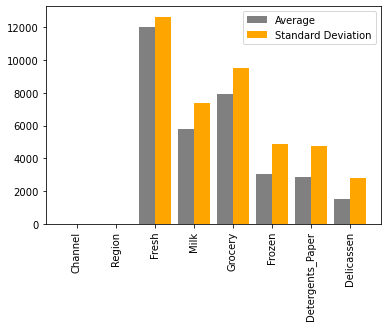

In [5]:
#plot the data

plt.bar(x_ix-0.2, averages, color='grey', label='Average', width=0.4)
plt.bar(x_ix+0.2, std_dev, color='orange', label='Standard Deviation', width=0.4)
plt.xticks(x_ix, x_names, rotation=90)
plt.legend()
plt.show()

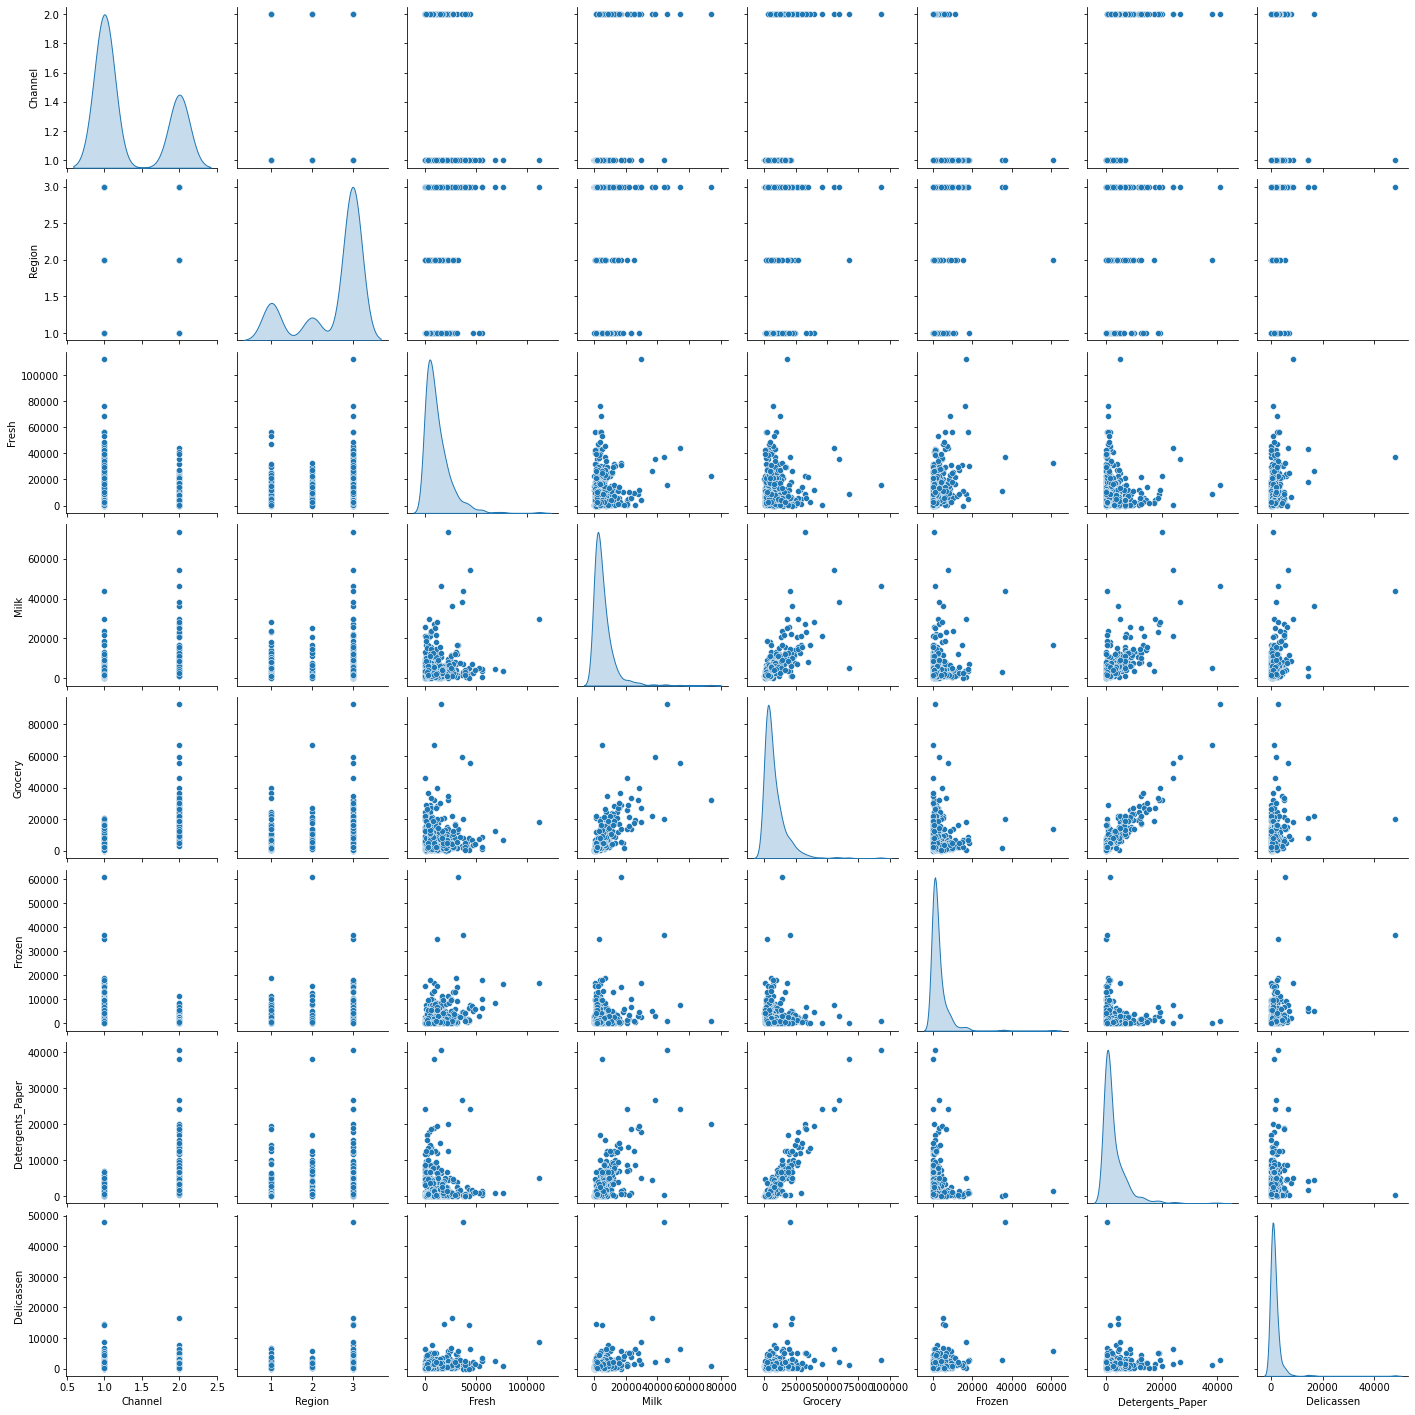

In [6]:
sns.pairplot(data=wholesale, diag_kind='kde')


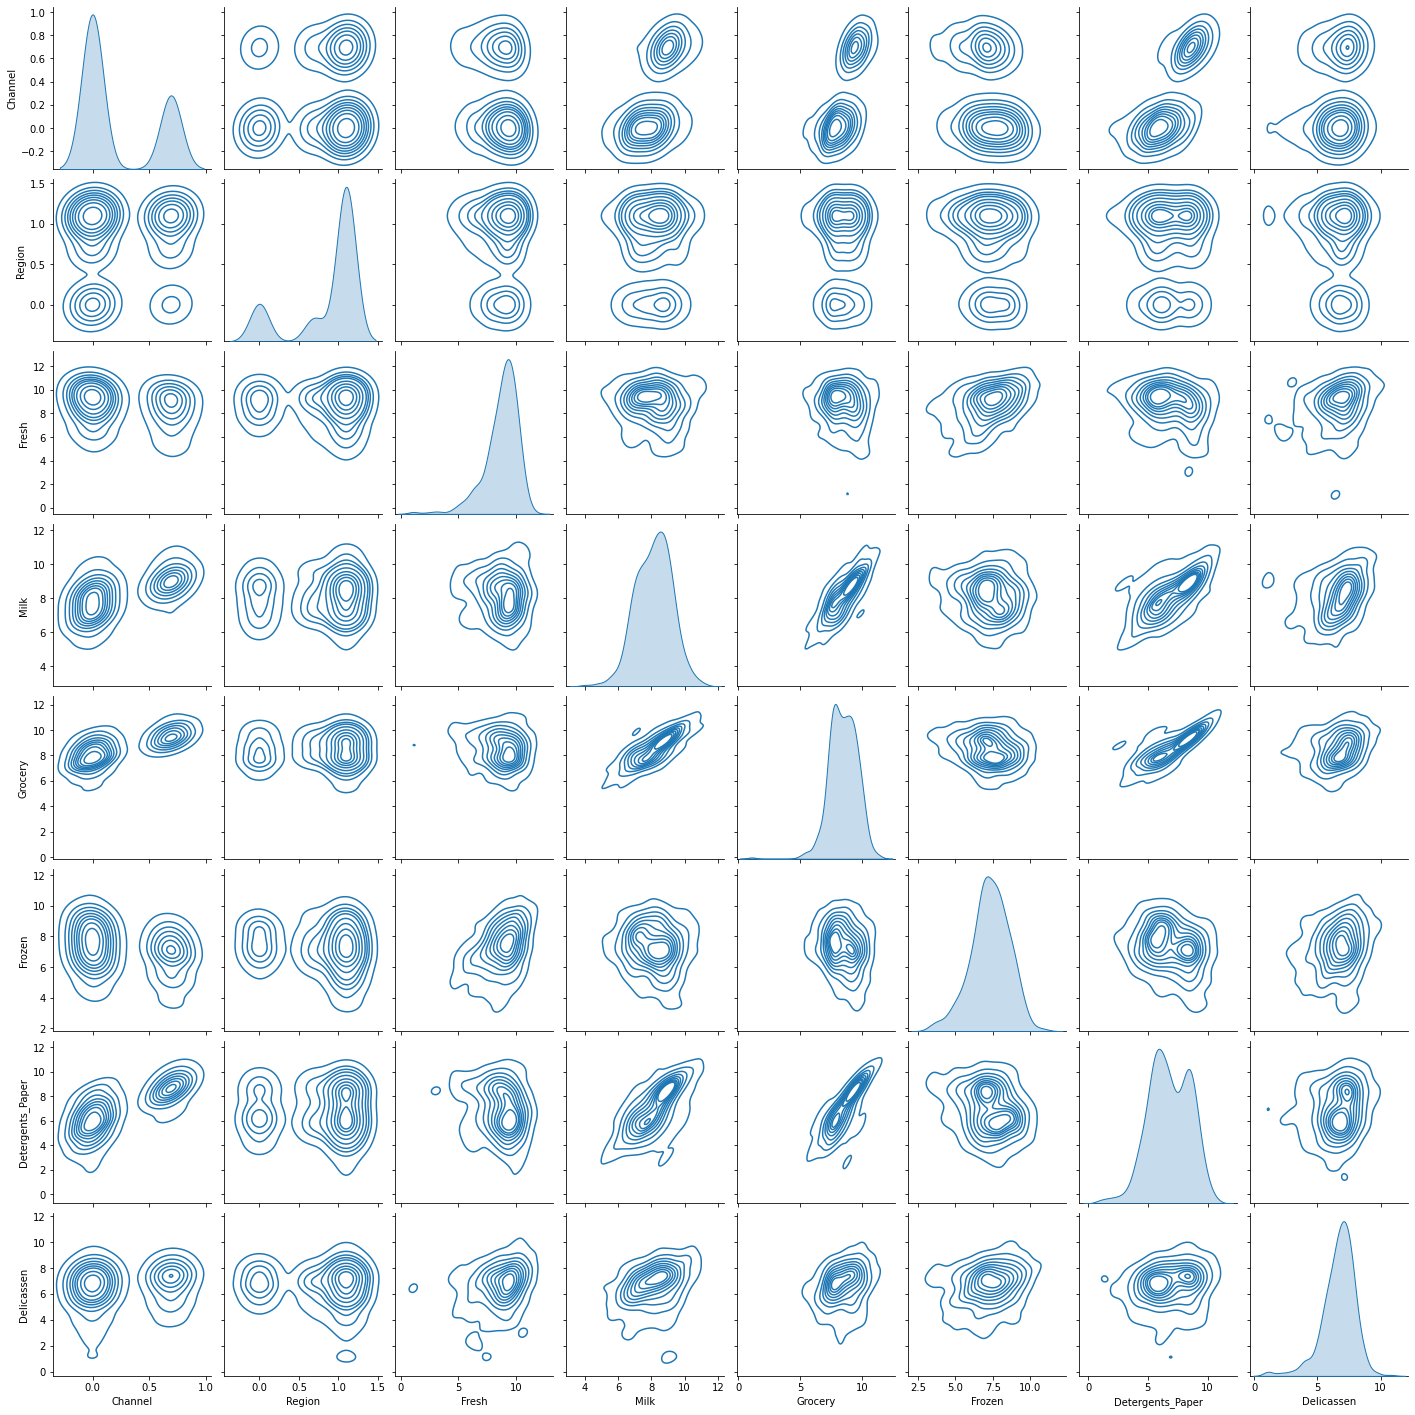

In [7]:
# unskewung data with log transformation
wholesale_log = np.log(wholesale)
sns.pairplot(wholesale_log, kind='kde')

In [8]:
# unskewing data with box-cox transformation

def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)


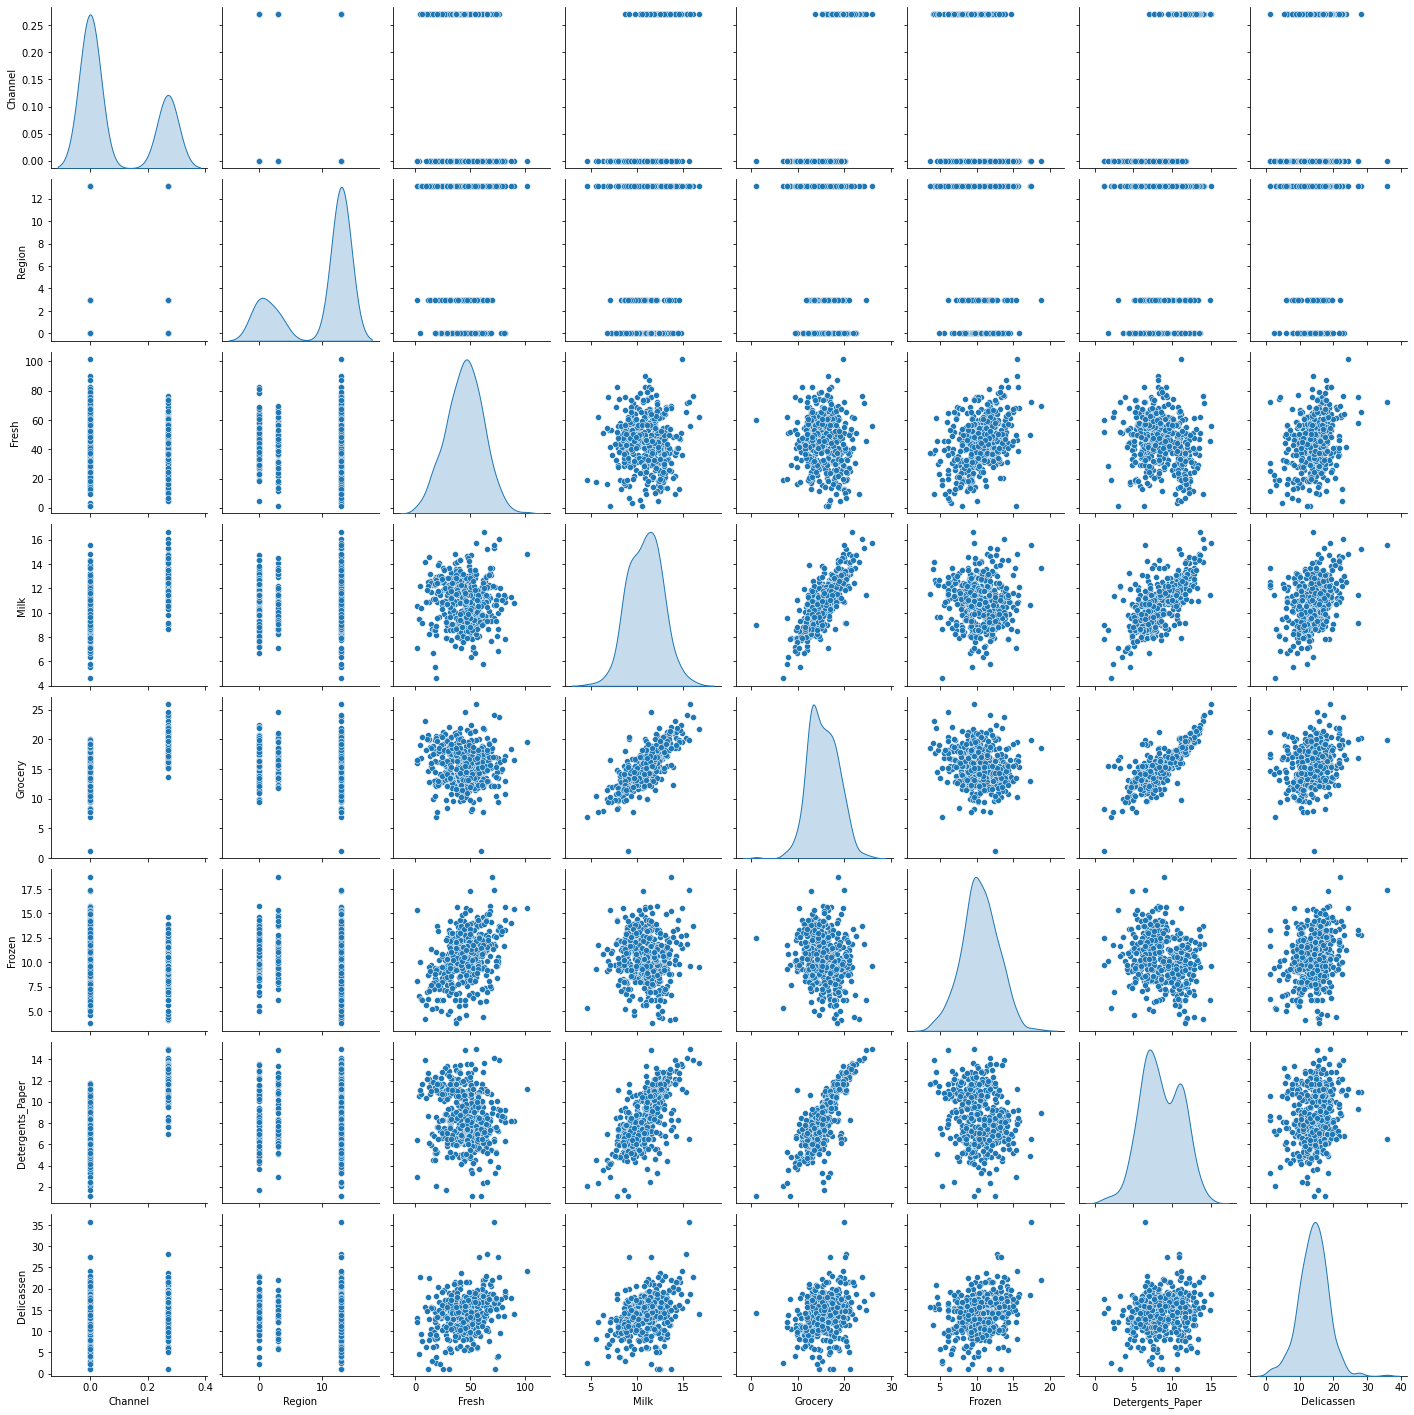

In [9]:
sns.pairplot(wholesale_boxcox, diag_kind='kde')

In [10]:
# scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled, index=wholesale_boxcox.index, columns=wholesale_boxcox.columns)

wholesale_scaled_df.agg(['mean', 'std']).round()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### CUSTOMER AND PRODUCT SEGMENTATION USING KMEANS

C:\Users\EM\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<AxesSubplot:title={'center':'Elbow criterion method chart'}>

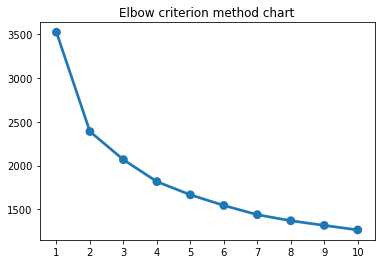

In [11]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

In [12]:

k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(wholesale_scaled_df)

wholesale_kmeans4 = wholesale.assign(segment=kmeans.labels_)

In [13]:
# analyze average k-mean segmentation attributes

kmeans4_average = wholesale_kmeans4.groupby(['segment']).mean().round(0)
kmeans4_average

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
segment,,,,,,,,
0,2.0,3.0,8211.0,10905.0,16618.0,1397.0,7499.0,1712.0
1,1.0,1.0,11499.0,2530.0,3736.0,3176.0,728.0,971.0
2,1.0,3.0,26298.0,6640.0,5977.0,8478.0,947.0,3465.0
3,1.0,3.0,9089.0,2314.0,2924.0,2038.0,574.0,728.0


<AxesSubplot:xlabel='segment'>

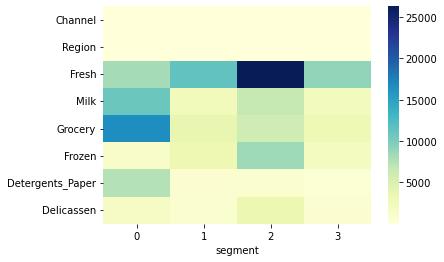

In [14]:
sns.heatmap(kmeans4_average.T, cmap='YlGnBu')

<ul>
    <li>SEGMENT 0 : HEAVY USER OF FRESH, MILK, GROCERY AND PAPER PRODUCTS</li>
    <li>SEGMENT 1 : MOSTLY FRESH PRODUCE SLIGHTLY LESSER THAN SEGMENT 2</li>
    <li>SEGMENT 2 : HEAVY BUYERS OF FRESH, FROZEN PRODUCE AND MILK</li>
    <li>SEGMENT 3 : MOSTLY FRESH PRODUCE BUT LESSER THAN SEGMENT 1</li>
</ul>


#### CUSTOMER SEGMENTATION WITH NON-NEGATIVE MATRIX FACTORIZATION

In [15]:
from sklearn.decomposition import NMF 
nmf = NMF(k)
nmf.fit(wholesale)

components = pd.DataFrame(nmf.components_, columns=wholesale.columns)

# extracting segment assignment
segment_weights = pd.DataFrame(nmf.transform(wholesale), columns=components.index)
segment_weights.index = wholesale.index
wholesale_nmf = wholesale.assign(segment = segment_weights.idxmax(axis=1))

C:\Users\EM\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [16]:
nmf4_averages = wholesale_nmf.groupby('segment').mean().round(0)

<AxesSubplot:xlabel='segment'>

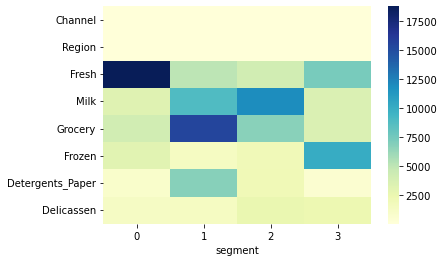

In [17]:
sns.heatmap(nmf4_averages.T, cmap='YlGnBu')

<ul>
    <li>SEGMENT 0 : MOSTLY FRESH PRODUCE</li>
    <li>SEGMENT 1 : HEAVY USER OF FRESH PRODUCE, MILK, GROCERY AND PAPER PRODUCTS</li>
    <li>SEGMENT 2 : HEAVY MILK AND GROCERY SHOPPER</li>
    <li>SEGMENT 3 : MOSTLY FROZEN AND FRESH PRODUCE</li>
</ul>


### 3 CLUSTERS SEGMENTATION

In [19]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(wholesale_scaled_df)

wholesale_kmeans3 = wholesale.assign(segment=kmeans.labels_)

In [20]:
# analyze average k-mean segmentation attributes

kmeans3_average = wholesale_kmeans3.groupby(['segment']).mean().round(0)
kmeans3_average

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
segment,,,,,,,,
0,1.0,2.0,23091.0,5397.0,5567.0,7213.0,907.0,2812.0
1,1.0,3.0,8769.0,2272.0,2903.0,2058.0,576.0,695.0
2,2.0,3.0,8192.0,10882.0,16576.0,1388.0,7475.0,1701.0


<AxesSubplot:xlabel='segment'>

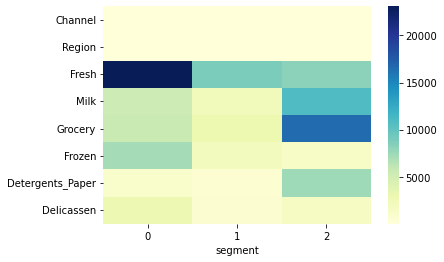

In [21]:
sns.heatmap(kmeans3_average.T, cmap='YlGnBu')

<ul>
    <li>SEGMENT 2 : HEAVY USER OF FRESH, MILK, GROCERY, DETERGENT AND PAPER PRODUCTS</li>
    <li>SEGMENT 1 : MOSTLY FRESH PRODUCE </li>
    <li>SEGMENT 0 : HEAVY BUYERS OF FRESH, FROZEN PRODUCE</li>
</ul>


In [22]:
k = 3
nmf3 = NMF(k)
nmf3.fit(wholesale)

components = pd.DataFrame(nmf3.components_, columns=wholesale.columns)

# extracting segment assignment
segment_weights = pd.DataFrame(nmf3.transform(wholesale), columns=components.index)
segment_weights.index = wholesale.index
wholesale_nmf3 = wholesale.assign(segment = segment_weights.idxmax(axis=1))

C:\Users\EM\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [23]:
nmf3_averages = wholesale_nmf3.groupby('segment').mean().round(0)

<AxesSubplot:xlabel='segment'>

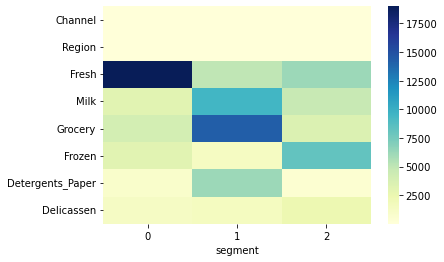

In [24]:
sns.heatmap(nmf3_averages.T, cmap='YlGnBu')

<ul>
    <li>SEGMENT 0 : MOSTLY FRESH PRODUCE </li>
    <li>SEGMENT 1 : HEAVY USER OF FRESH, MILK, GROCERY, DETERGENT AND PAPER PRODUCTS</li>
    <li>SEGMENT 2 : HEAVY BUYERS OF FRESH, FROZEN PRODUCE</li>
</ul>
